In [45]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt 
import os

In [85]:
img = cv2.imread('mrz_samples/test.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

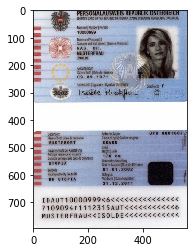

In [86]:
plt.imshow(img)

In [87]:
def extract_MRZ(img,aspect_ratio_thresh,width_thresh):
    fig,ax=plt.subplots(2,3,figsize=(20,20))
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))

    img = imutils.resize(img, height=600)
    
#     img=np.pad(img, ((10, 10), (10, 10), (0, 0)), mode='constant')
   
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    ax[0,0].imshow(gray,cmap='gray')
    # morphologyEx bakchat Highlight dark regions with light background
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
    ax[0,1].imshow(blackhat,cmap='gray')

    # Gradient X and sobel will connect the white parts of image in horizontal direction
    gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
    ax[0,2].imshow(gradX,cmap='gray')
    
#   cv2.MORPH_CLOSE is Dilation followed by Erosion means it will fill the small holes inside a white region
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
    ax[1,0].imshow(gradX,cmap='gray')
    
    thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ax[1,1].imshow(thresh,cmap='gray')
    thresh = cv2.erode(thresh, None, iterations=2)
    # similar close operation but this time it will fill the holes in square like shapes
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    ax[1,2].imshow(thresh,cmap='gray')
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # loop over the contours
    boxes = []
    roi_list=[]
    image=img.copy()
    for c in cnts:
        # compute the bounding box of the contour and use the contour to
        # compute the aspect ratio and coverage ratio of the bounding box
        # width to the width of the image
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        crWidth = w / float(gray.shape[1])
        # check to see if the aspect ratio and coverage width are within
        # acceptable criteria

        if ar > aspect_ratio_thresh and crWidth > width_thresh:
            # pad the bounding box since we applied erosions and now need
            # to re-grow it
           
            pX = int((x + w) * 0.05)
            pY = int((y + h) * 0.05)
            (x, y) = (x - pX, y - pY)
            (w, h) = (w + (pX * 2), h + (pY * 2))
            x = max(x, 0)
            # extract the ROI from the image and draw a bounding box
            # surrounding the MRZ
            roi = img[y:y + h, x:x + w].copy()
            roi_list.append(roi)
            image=cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # print((x,y),(x+w,y+h))
            boxes.append({"x1":x,"y1":y,"x2":x+w,"y2":y+h})


            # break
    # show the output images
    # cv2.imshow("Image", image)

    return image,boxes

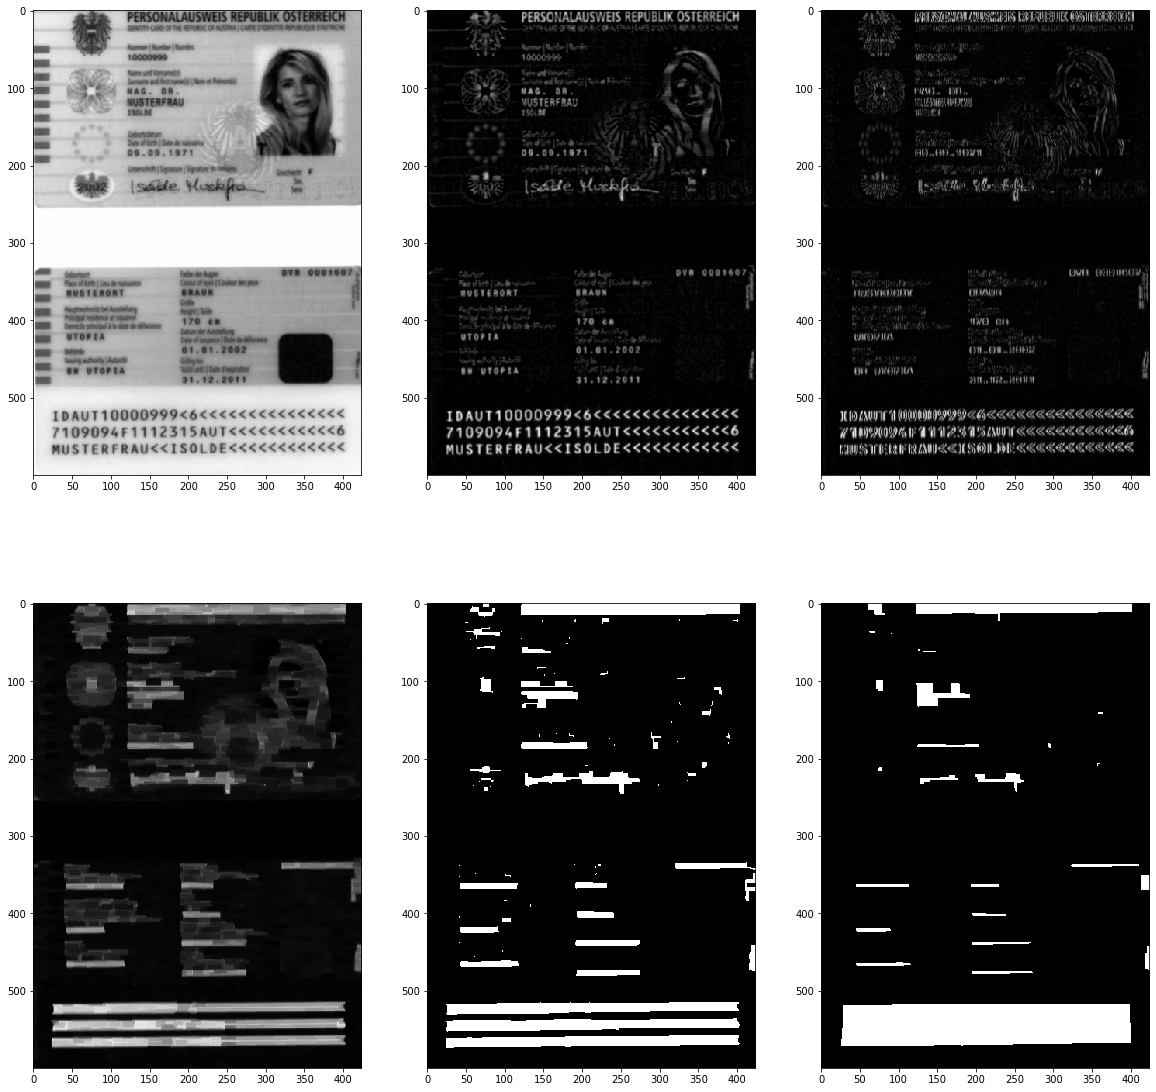

In [88]:
img,boxes=extract_MRZ(img,3,0.5) 

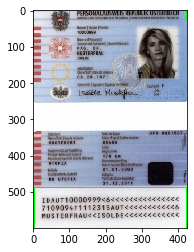

In [89]:
plt.imshow(img)

In [25]:

def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def merge_boxes(bbox1,bbox2):
    y1 = min(bbox1["y1"],bbox2["y1"])
    y2= max(bbox1["y2"],bbox2["y2"])
    x1=min(bbox1['x1'],bbox2['x1'])
    x2 = max(bbox1['x2'], bbox2['x2'])
    bbox1["x1"] = x1
    bbox1["x2"] = x2
    bbox1["y1"]=y1
    bbox1["y2"]=y2
    return bbox1


In [26]:
def remove_dublicate_boxes(boxes):
    dublicate = [False]*(len(boxes))
    for i in range(len(boxes)):
        for j in range(i+1,len(boxes)):
            if(boxes[i]==boxes[j]):
                dublicate[j]=1
    unique=[]
    for idx,box in zip(dublicate,boxes):
        if(idx==False):
            unique.append(box)


    return unique


def refine_boxes(boxes):
    ref_boxes=[]
    last = False
    for i in range(len(boxes)-1):
        if get_iou(boxes[i],boxes[i+1])>0:
            new_box = merge_boxes(boxes[i],boxes[i+1])
            boxes[i+1]=new_box

            ref_boxes.append(new_box)
            last=True
        else:
            ref_boxes.append(boxes[i])
            last=False
    if last==False:
        ref_boxes.append(boxes[-1])